# 事前準備

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import copy
from glob import glob
import itertools
import math
import os
from pathlib import Path
import shutil
from typing import Callable, Literal, Optional, Type
import warnings

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid



In [37]:
BATCH_SIZE = 64
IMAGE_SIZE = 256  # 一辺のピクセル数
MAX_EPOCHS = 30  # 学習時の最大エポック数

# ImageNet統計に基づく正規化パラメータ
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

ROOT_DIR_PATH = Path('/content/drive/MyDrive/python-business-ml-starter')
DIR_DATA = ROOT_DIR_PATH / "data"
DIR_DATA_UNKNOWN = DIR_DATA / "unknown"
DIR_MODELS = ROOT_DIR_PATH / "models"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [4]:
os.makedirs(DIR_DATA, exist_ok=True)
os.makedirs(DIR_DATA_UNKNOWN, exist_ok=True)
os.makedirs(DIR_MODELS, exist_ok=True)

# データ観察

In [5]:
ALL_LABELS = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]
LABELS_TO_USE = ["bird", "cat", "deer", "dog", "horse", "monkey"]

NUM_CLASSES = len(ALL_LABELS)
LABELS_MAP = {
    i: LABELS_TO_USE.index(label)
    for i, label in enumerate(ALL_LABELS) if label in LABELS_TO_USE
}


In [6]:
eval_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [7]:
def create_STL10_dataloader(
    split: str,
    dir_to_save: Path = DIR_DATA,
    transform: Tensor = eval_transforms,
) -> DataLoader:
    dataset = datasets.STL10(
        root=dir_to_save,
        split=split,
        download=True,
        transform=transform,
    )

    if set(LABELS_TO_USE) != set(dataset.classes):
        indices_to_use = {
            dataset.classes.index(cat) for cat in LABELS_TO_USE
        }
        indices = [
            i for i, label in enumerate(dataset.labels)
            if label in indices_to_use
        ]
        dataset = Subset(dataset, indices)
        dataset.classes = ALL_LABELS

    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle= True,
        num_workers=os.cpu_count(),
    )


In [8]:
def destandardize(tensor: Tensor):
    for t, m, s in zip(tensor, IMAGENET_MEAN, IMAGENET_STD):
        t.mul_(s).add_(m)
    return tensor

In [9]:
def show_images_of_first_batch(dataloader: DataLoader):
    torch.manual_seed(0)
    X, y = next(iter(dataloader))
    nrow = 4
    plt.figure(figsize=(
        2 * nrow,
        2 * math.ceil(BATCH_SIZE / nrow)
    ))
    plt.imshow(
        make_grid(
            [destandardize(x) for x in X],
            nrow=nrow, padding=8, pad_value=1
        ).permute(1, 2, 0)
    )


In [10]:
dataloader_for_display = create_STL10_dataloader(
    split="train",
)


Files already downloaded and verified


In [11]:
show_images_of_first_batch(dataloader_for_display)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
def show_raw_images_of_first_batch(dataloader: DataLoader):
    torch.manual_seed(0)
    images, labels = next(iter(dataloader))
    print("Shape of X [N, C, H, W]: ", images.shape)
    print(images[0])
    print("Shape of y: ", labels.shape, labels.dtype)
    print(labels)


In [13]:
show_raw_images_of_first_batch(dataloader_for_display)

Shape of X [N, C, H, W]:  torch.Size([64, 3, 256, 256])
tensor([[[-0.2513, -0.2513, -0.2513,  ..., -0.3369, -0.3369, -0.3369],
         [-0.2513, -0.2513, -0.2513,  ..., -0.3369, -0.3369, -0.3369],
         [-0.2513, -0.2513, -0.2513,  ..., -0.3369, -0.3369, -0.3369],
         ...,
         [-0.2856, -0.2856, -0.2856,  ..., -0.4226, -0.4226, -0.4226],
         [-0.2856, -0.2856, -0.2856,  ..., -0.4226, -0.4226, -0.4226],
         [-0.2856, -0.2856, -0.2856,  ..., -0.4226, -0.4226, -0.4226]],

        [[ 0.0476,  0.0476,  0.0476,  ..., -0.0924, -0.0924, -0.0924],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.0924, -0.0924, -0.0924],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.0924, -0.0924, -0.0924],
         ...,
         [-0.0399, -0.0399, -0.0399,  ..., -0.1800, -0.1800, -0.1800],
         [-0.0399, -0.0399, -0.0399,  ..., -0.1800, -0.1800, -0.1800],
         [-0.0399, -0.0399, -0.0399,  ..., -0.1800, -0.1800, -0.1800]],

        [[ 0.7402,  0.7402,  0.7402,  ...,  0.5834,  0.5834,

In [14]:
dataloader_for_display.dataset.classes

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

# 機械学習モデル1：シンプルなモデル（全結合ネットワーク）

In [15]:
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        layer_width = 1024
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * IMAGE_SIZE * IMAGE_SIZE, layer_width),
            nn.BatchNorm1d(layer_width),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(layer_width, layer_width),
            nn.BatchNorm1d(layer_width),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(layer_width, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [16]:
# 連続何回エポック更新がされないときに学習を打ち切るか
early_stopped_not_updated_times = 5

class NeuralNetworkModelWrapper:
    def __init__(
        self, model_class: Type[nn.Module],
        model_file_name: str,
        extra_func: Optional[Callable] = None,
    ):
        self.model_class = model_class
        self.extra_func = extra_func
        self.model = self._initialize_model()

        self.model_file_name = model_file_name
        self.acc_train = []
        self.acc_test = []
        self.acc_test_best = None

    def _initialize_model(self):
        model = self.model_class()
        if self.extra_func is not None:
            model = self.extra_func(model)
        model = model.to(DEVICE)
        print(model)
        return model

    def _epoch_iteration(
        self, dataloader: DataLoader, loss_fn,
        phase: Literal["train", "test"], dataset_type: str,
        optimizer=None,
        num_batches_for_test: int = 20,
    ):
        if phase == "train":
            self.model.train()
        elif phase == "test":
            self.model.eval()
        else:
            raise RuntimeError('phase should be either of "train" or "test')

        loss_sum, correct_sum, num_images = 0, 0, 0

        if phase == "train":
            num_batches = len(dataloader)
        else:
            num_batches = num_batches_for_test

        with torch.set_grad_enabled(phase=="train"), \
                tqdm(total=num_batches, unit="batch") as pbar:
            desc = f"{phase} with {dataset_type} dataset"
            pbar.set_description(f"{desc:27s}")
            for batch_i, (X, y) in enumerate(dataloader):
                if phase == "test" and batch_i == num_batches_for_test:
                    break

                X, y = X.to(DEVICE), y.to(DEVICE)

                # 損失を計算
                pred = self.model(X)
                loss = loss_fn(pred, y)

                # 誤差逆伝播
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # 損失・正解数を加算
                loss_sum += loss.item()
                correct_sum += (pred.argmax(1) == y).type(torch.float).sum().item()

                num_images += len(X)

                pbar.set_postfix({
                    "loss": f"{loss_sum / (batch_i + 1):>6.3f}",
                    "accuracy": f"{100 * correct_sum / num_images:>5.1f}%"
                })
                pbar.update(1)

        accuracy = correct_sum / num_images
        return accuracy

    def learn(
        self, max_epochs: int,
        dataloader_train: DataLoader,
        dataloader_test: DataLoader,
        loss_fn = None, optimizer = None,
        seed: int = 0,
        save: bool = True,
    ):
        if loss_fn is None:
            loss_fn = nn.CrossEntropyLoss()
        if optimizer is None:
            optimizer = torch.optim.SGD(
                self.model.parameters(), lr=1e-3, momentum=0.9
            )
        torch.manual_seed(seed)
        acc_train = []
        acc_test = []
        self.acc_test_best = 0.0
        best_model_weights = copy.deepcopy(self.model.state_dict())
        num_not_updated = 0
        for t in range(max_epochs + 1):
            print(f"Epoch {t}\n-------------------------------")
            if t != 0:
                self._epoch_iteration(
                    dataloader_train, loss_fn, phase="train",
                    dataset_type="training", optimizer=optimizer
                )
            _acc_train = self._epoch_iteration(
                dataloader_train, loss_fn, phase="test",
                dataset_type="training"
            )
            acc_train.append(_acc_train)
            _acc_test = self._epoch_iteration(
                dataloader_test, loss_fn, phase="test",
                dataset_type="testing"
            )
            acc_test.append(_acc_test)

            if _acc_test > self.acc_test_best:
                best_model_weights = copy.deepcopy(self.model.state_dict())
                print(
                    "Best test accuracy has been updated "
                    f"({100 * self.acc_test_best:>5.1f}% -> {100 * _acc_test:>5.1f}%)"
                )
                self.acc_test_best = _acc_test
                num_not_updated = 0
            else:
                print("Best test accuracy has not been updated "
                      f"({100 * self.acc_test_best:>5.1f}%)"
                )
                num_not_updated += 1
                if num_not_updated == early_stopped_not_updated_times:
                    print(
                        "Stopped because the best test accuracy "
                        "has not been updated for 5 epochs in a row."
                    )
                    break

            print()
        self.model.load_state_dict(best_model_weights)
        self.acc_train = acc_train
        self.acc_test = acc_test
        print("Done!")

        if save:
            self.save()

    def save(self):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "eval_results": {
                    "acc_train": self.acc_train,
                    "acc_test": self.acc_test,
                    "acc_test_best": self.acc_test_best,
                }
            },
            DIR_MODELS / self.model_file_name
        )
        print("Saved")

    def load(self):
        path = DIR_MODELS / self.model_file_name
        if os.path.exists(path):
            artifacts = torch.load(
                DIR_MODELS / self.model_file_name,
                map_location=DEVICE,
            )
            self.model.load_state_dict(
                artifacts["model_state_dict"]
            )
            self.acc_train = artifacts["eval_results"]["acc_train"]
            self.acc_test = artifacts["eval_results"]["acc_test"]
            self.acc_test_best = artifacts["eval_results"]["acc_test_best"]
            print("Loaded")
            return True
        else:
            print(f"{path} does not exist")
            return False

    def predict(
        self,
        dataloader: DataLoader,
        num_batches = None,
        seed: int = 0
    ) -> pd.DataFrame:
        torch.manual_seed(seed)
        self.model.eval()
        correct1 = 0
        correct3 = 0
        for i, (X, y) in enumerate(dataloader):
            if i == num_batches:
                break

            X, y = X.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                scores = F.softmax(self.model(X), dim=1)
                predicted_labels = torch.argsort(scores, dim=1, descending=True)

            for j in range(len(y)):
                actual_label = dataloader.dataset.classes[y[j]]

                plt.figure(figsize=(3.2, 2.4))
                plt.imshow(destandardize(X[j]).cpu().permute(1, 2, 0))
                plt.title(actual_label)
                plt.show()

                add_correct3 = False
                for k in range(3):
                    label_index = predicted_labels[j, k]
                    label = LABELS_TO_USE[LABELS_MAP[int(label_index)]]
                    add_correct3 |= actual_label == label
                    correct1 += 1 if k == 0 and actual_label == label else 0
                    print(
                        f"{label:<10s}: "
                        f"{100 * scores[j, label_index]:5.1f}%"
                    )
                correct3 += add_correct3
                print()

        has_actual_labels = len(
            set(dataloader.dataset.classes) &
            set(LABELS_TO_USE)
        ) > 0

        if has_actual_labels:
            print(f"Acc@1 = {correct1/len(y):.1%} ({correct1}/{len(y)})")
            print(f"Acc@3 = {correct3/len(y):.1%} ({correct3}/{len(y)})")

    def load_and_predict(self, dataloader: DataLoader):
        self.load()
        self.predict(dataloader)


## モデルの学習

In [17]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


In [18]:
# STL10用データローダの生成
dataloader_train = create_STL10_dataloader(
    split="train",
    transform=train_transforms,
)
dataloader_test = create_STL10_dataloader(
    split="test",
    transform=eval_transforms,  # eval_transforms はデータ観察の項で定義済
)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
fcnn = NeuralNetworkModelWrapper(FullyConnectedNeuralNetwork, "fcnn.pth")

FullyConnectedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=196608, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [20]:
fcnn.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
)

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.77batch/s, loss=2.329, accuracy=6.0%]


Best test accuracy has been updated (  0.0% ->   6.0%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:06<00:00,  3.08batch/s, loss=1.737, accuracy=33.0%]


Best test accuracy has been updated (  6.0% ->  33.0%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.85batch/s, loss=1.694, accuracy=33.6%]


Best test accuracy has been updated ( 33.0% ->  33.6%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.42batch/s, loss=1.632, accuracy=35.2%]


Best test accuracy has been updated ( 33.6% ->  35.2%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.89batch/s, loss=1.619, accuracy=37.2%]


Best test accuracy has been updated ( 35.2% ->  37.2%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.64batch/s, loss=1.613, accuracy=36.6%]


Best test accuracy has not been updated ( 37.2%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.74batch/s, loss=1.604, accuracy=35.8%]


Best test accuracy has not been updated ( 37.2%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.08batch/s, loss=1.608, accuracy=36.6%]


Best test accuracy has not been updated ( 37.2%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.88batch/s, loss=1.564, accuracy=38.9%]


Best test accuracy has been updated ( 37.2% ->  38.9%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.59batch/s, loss=1.577, accuracy=36.4%]


Best test accuracy has not been updated ( 38.9%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.34batch/s, loss=1.567, accuracy=36.5%]


Best test accuracy has not been updated ( 38.9%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.67batch/s, loss=1.555, accuracy=39.0%]


Best test accuracy has been updated ( 38.9% ->  39.0%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.86batch/s, loss=1.553, accuracy=38.1%]


Best test accuracy has not been updated ( 39.0%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.85batch/s, loss=1.543, accuracy=40.2%]


Best test accuracy has been updated ( 39.0% ->  40.2%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.09batch/s, loss=1.546, accuracy=38.6%]


Best test accuracy has not been updated ( 40.2%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.94batch/s, loss=1.548, accuracy=37.8%]


Best test accuracy has not been updated ( 40.2%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.77batch/s, loss=1.497, accuracy=41.0%]


Best test accuracy has been updated ( 40.2% ->  41.0%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.68batch/s, loss=1.509, accuracy=41.6%]


Best test accuracy has been updated ( 41.0% ->  41.6%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.90batch/s, loss=1.518, accuracy=40.2%]


Best test accuracy has not been updated ( 41.6%)

Epoch 19
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.95batch/s, loss=1.537, accuracy=40.2%]


Best test accuracy has not been updated ( 41.6%)

Epoch 20
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.34batch/s, loss=1.513, accuracy=41.2%]


Best test accuracy has not been updated ( 41.6%)

Epoch 21
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.97batch/s, loss=1.439, accuracy=43.1%]


Best test accuracy has been updated ( 41.6% ->  43.1%)

Epoch 22
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.87batch/s, loss=1.494, accuracy=42.4%]


Best test accuracy has not been updated ( 43.1%)

Epoch 23
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.02batch/s, loss=1.484, accuracy=42.3%]


Best test accuracy has not been updated ( 43.1%)

Epoch 24
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.75batch/s, loss=1.516, accuracy=40.0%]


Best test accuracy has not been updated ( 43.1%)

Epoch 25
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.72batch/s, loss=1.492, accuracy=41.7%]


Best test accuracy has not been updated ( 43.1%)

Epoch 26
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.89batch/s, loss=1.497, accuracy=40.9%]


Best test accuracy has not been updated ( 43.1%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [21]:
# モデルが保存されていればロードするだけでOK
# fcnn.load()

In [22]:
def plot_accuracy(accuracy: dict[str, list[float]], title: Optional[str] = None):
    sns.lineplot(accuracy)
    plt.xlabel(f"epochs")
    plt.ylabel(f"accuracy")
    if title is not None:
        plt.title(title)

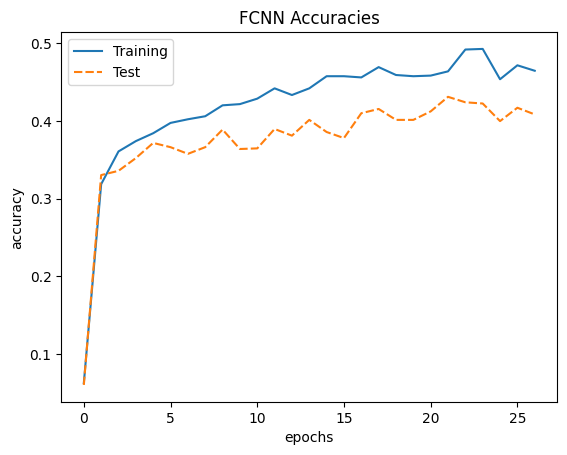

In [23]:
plot_accuracy({
    "Training": fcnn.acc_train,
    "Test": fcnn.acc_test,
}, title="FCNN Accuracies")

## モデルを使った予測・評価

In [24]:
fcnn.predict(dataloader_test, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
# GitHub リポジトリ上のサンプル未知画像データを Google Drive に保存
import requests

base_url = "https://raw.githubusercontent.com/ml-pg-book/" + \
           "python-business-ml-starter/main/chapter4/" + \
           "4.3.%20画像データ:%20画像を識別してみよう/"

for animal in ["bird", "cat", "deer", "dog", "horse"]:
    os.makedirs(DIR_DATA_UNKNOWN / animal, exist_ok=True)
    response = requests.get(base_url + f"example_{animal}.jpg")
    with open(DIR_DATA_UNKNOWN / animal / f"example_{animal}.jpg", "wb") as file:
        file.write(response.content)

In [29]:
def create_image_folder_dataloader(
    dir_to_load: Path,
    transform: Tensor = transforms.ToTensor(),
) -> DataLoader:
    for path in glob(f'{dir_to_load / "**" / ".ipynb_checkpoints"}', recursive=True):
        shutil.rmtree(path)

    dataset = datasets.ImageFolder(dir_to_load, transform=transform)

    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count(),
    )


In [38]:
# Image Folder用データローダの生成
dataloader_unknown = create_image_folder_dataloader(
    dir_to_load=DIR_DATA_UNKNOWN,
    transform=eval_transforms,
)

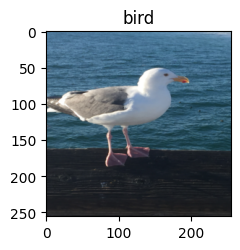

bird      :  36.9%
deer      :  19.1%
monkey    :  14.5%



Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


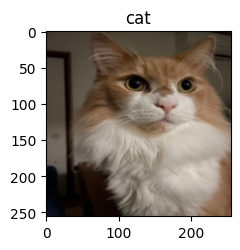

cat       :  58.5%
dog       :  17.9%
bird      :  10.2%



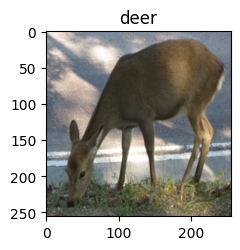

horse     :  38.8%
monkey    :  16.6%
dog       :  14.6%



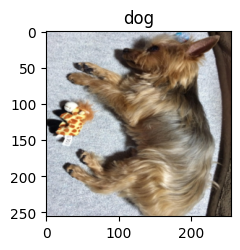

dog       :  27.0%
cat       :  23.1%
bird      :  16.1%



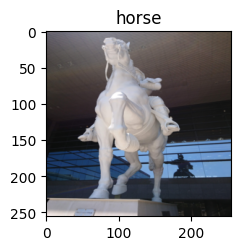

bird      :  51.6%
monkey    :  16.8%
cat       :  14.9%

Acc@1 = 60.0% (3/5)
Acc@3 = 60.0% (3/5)


In [39]:
fcnn.predict(dataloader_unknown)

# 機械学習モデル２：CNN（畳み込みニューラルネットワーク）モデルの実装・学習

In [40]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        fc_size = 4096
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(
                256 * 7 * 7, fc_size
            ),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, fc_size),
            nn.ReLU(inplace=True),
            nn.Linear(fc_size, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## モデルの学習

In [41]:
cnn = NeuralNetworkModelWrapper(ConvolutionalNeuralNetwork, "cnn.pth")

ConvolutionalNeuralNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=Tru

In [42]:
cnn.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    save=False
)

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.52batch/s, loss=2.302, accuracy=14.5%]


Best test accuracy has been updated (  0.0% ->  14.5%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.39batch/s, loss=1.696, accuracy=30.9%]


Best test accuracy has been updated ( 14.5% ->  30.9%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.30batch/s, loss=1.577, accuracy=38.2%]


Best test accuracy has been updated ( 30.9% ->  38.2%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.91batch/s, loss=1.533, accuracy=39.1%]


Best test accuracy has been updated ( 38.2% ->  39.1%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.60batch/s, loss=1.382, accuracy=48.7%]


Best test accuracy has been updated ( 39.1% ->  48.7%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.21batch/s, loss=1.356, accuracy=48.4%]


Best test accuracy has not been updated ( 48.7%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.98batch/s, loss=1.256, accuracy=52.3%]


Best test accuracy has been updated ( 48.7% ->  52.3%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.49batch/s, loss=1.308, accuracy=51.9%]


Best test accuracy has not been updated ( 52.3%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.55batch/s, loss=1.497, accuracy=46.7%]


Best test accuracy has not been updated ( 52.3%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.88batch/s, loss=1.265, accuracy=51.5%]


Best test accuracy has not been updated ( 52.3%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.40batch/s, loss=1.231, accuracy=55.2%]


Best test accuracy has been updated ( 52.3% ->  55.2%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.44batch/s, loss=1.229, accuracy=54.3%]


Best test accuracy has not been updated ( 55.2%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.53batch/s, loss=1.364, accuracy=52.1%]


Best test accuracy has not been updated ( 55.2%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.37batch/s, loss=1.235, accuracy=54.7%]


Best test accuracy has not been updated ( 55.2%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.52batch/s, loss=1.564, accuracy=47.3%]


Best test accuracy has not been updated ( 55.2%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.51batch/s, loss=1.288, accuracy=56.5%]


Best test accuracy has been updated ( 55.2% ->  56.5%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.79batch/s, loss=1.201, accuracy=56.0%]


Best test accuracy has not been updated ( 56.5%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.47batch/s, loss=1.785, accuracy=44.5%]


Best test accuracy has not been updated ( 56.5%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.71batch/s, loss=1.014, accuracy=63.0%]


Best test accuracy has been updated ( 56.5% ->  63.0%)

Epoch 19
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.49batch/s, loss=1.218, accuracy=60.2%]


Best test accuracy has not been updated ( 63.0%)

Epoch 20
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.65batch/s, loss=1.205, accuracy=57.7%]


Best test accuracy has not been updated ( 63.0%)

Epoch 21
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.51batch/s, loss=1.077, accuracy=62.1%]


Best test accuracy has not been updated ( 63.0%)

Epoch 22
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.73batch/s, loss=1.312, accuracy=56.0%]


Best test accuracy has not been updated ( 63.0%)

Epoch 23
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.82batch/s, loss=1.014, accuracy=64.5%]


Best test accuracy has been updated ( 63.0% ->  64.5%)

Epoch 24
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.70batch/s, loss=0.931, accuracy=66.9%]


Best test accuracy has been updated ( 64.5% ->  66.9%)

Epoch 25
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.56batch/s, loss=1.037, accuracy=64.0%]


Best test accuracy has not been updated ( 66.9%)

Epoch 26
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.10batch/s, loss=1.098, accuracy=63.0%]


Best test accuracy has not been updated ( 66.9%)

Epoch 27
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.87batch/s, loss=1.034, accuracy=63.4%]


Best test accuracy has not been updated ( 66.9%)

Epoch 28
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.58batch/s, loss=1.111, accuracy=63.7%]


Best test accuracy has not been updated ( 66.9%)

Epoch 29
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.66batch/s, loss=1.219, accuracy=61.0%]

Best test accuracy has not been updated ( 66.9%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!


In [43]:
# 既存のモデルが保存されていればロードするだけでOK
# cnn.load()

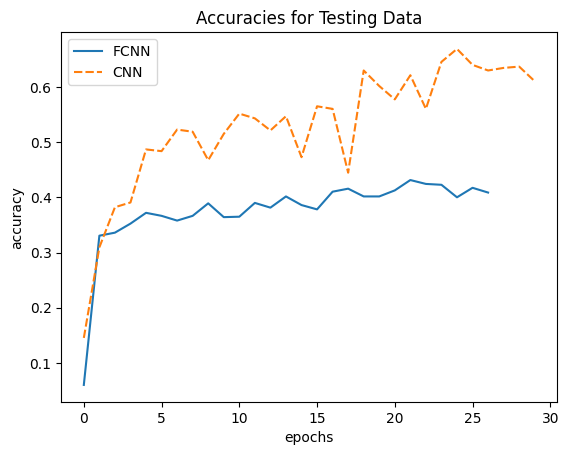

In [44]:
plot_accuracy({
    "FCNN": fcnn.acc_test,
    "CNN": cnn.acc_test
}, title="Accuracies for Testing Data")

# 機械学習モデル３：定義済みモデルの学習

## モデルの学習

In [45]:
def change_classifier(model):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(
        in_features=in_features,
        out_features=len(ALL_LABELS)
    ).to(DEVICE)
    return model

alexnet = NeuralNetworkModelWrapper(
    model_class=models.alexnet,
    model_file_name="alexnet.pth",
    extra_func=change_classifier,
)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [46]:
alexnet.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
)

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.32batch/s, loss=2.300, accuracy=16.3%]


Best test accuracy has been updated (  0.0% ->  16.3%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.43batch/s, loss=2.256, accuracy=16.8%]


Best test accuracy has been updated ( 16.3% ->  16.8%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.60batch/s, loss=2.140, accuracy=17.1%]


Best test accuracy has been updated ( 16.8% ->  17.1%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.82batch/s, loss=1.811, accuracy=16.6%]


Best test accuracy has not been updated ( 17.1%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.76batch/s, loss=1.799, accuracy=16.6%]


Best test accuracy has not been updated ( 17.1%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.50batch/s, loss=1.802, accuracy=18.4%]


Best test accuracy has been updated ( 17.1% ->  18.4%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.96batch/s, loss=1.800, accuracy=22.0%]


Best test accuracy has been updated ( 18.4% ->  22.0%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.22batch/s, loss=1.797, accuracy=19.3%]


Best test accuracy has not been updated ( 22.0%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.47batch/s, loss=1.798, accuracy=22.2%]


Best test accuracy has been updated ( 22.0% ->  22.2%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.68batch/s, loss=1.783, accuracy=23.7%]


Best test accuracy has been updated ( 22.2% ->  23.7%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.75batch/s, loss=1.796, accuracy=22.1%]


Best test accuracy has not been updated ( 23.7%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.71batch/s, loss=1.776, accuracy=23.8%]


Best test accuracy has been updated ( 23.7% ->  23.8%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.69batch/s, loss=1.774, accuracy=21.4%]


Best test accuracy has not been updated ( 23.8%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.85batch/s, loss=1.769, accuracy=25.0%]


Best test accuracy has been updated ( 23.8% ->  25.0%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.50batch/s, loss=1.759, accuracy=22.4%]


Best test accuracy has not been updated ( 25.0%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.46batch/s, loss=1.768, accuracy=22.6%]


Best test accuracy has not been updated ( 25.0%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.46batch/s, loss=1.758, accuracy=23.4%]


Best test accuracy has not been updated ( 25.0%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.77batch/s, loss=1.760, accuracy=23.2%]


Best test accuracy has not been updated ( 25.0%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.47batch/s, loss=1.761, accuracy=21.3%]


Best test accuracy has not been updated ( 25.0%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [47]:
# 既存のモデルが保存されていればロードするだけでOK
# alexnet.load()

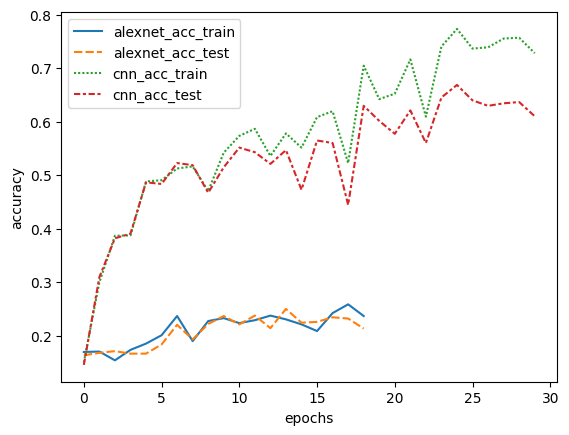

In [48]:
plot_accuracy({
    "alexnet_acc_train": alexnet.acc_train,
    "alexnet_acc_test": alexnet.acc_test,
    "cnn_acc_train": cnn.acc_train,
    "cnn_acc_test": cnn.acc_test
})

# 機械学習モデル４：転移学習（事前学習済みモデルの利用）

## モデルの学習

In [49]:
def change_model(model):
    model = torch.hub.load(
        "pytorch/vision", "alexnet", weights="IMAGENET1K_V1"
    ).to(DEVICE)
    for name, param in model.named_parameters():
        param.requires_grad = False
    model = change_classifier(model).to(DEVICE)
    return model

alexnet_pretrained = NeuralNetworkModelWrapper(
    model_class=models.alexnet,
    model_file_name="alexnet_pretrained.pth",
    extra_func=change_model,
)



Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 194MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [50]:
alexnet_pretrained.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
)

Epoch 0
-------------------------------


test with training dataset :  95%|█████████▌| 19/20 [00:03<00:00,  5.61batch/s, loss=2.418, accuracy=12.2%]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7deaf2f283a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _c

Best test accuracy has been updated (  0.0% ->  11.6%)

Epoch 1
-------------------------------


train with training dataset:  49%|████▉     | 23/47 [00:04<00:04,  5.88batch/s, loss=1.354, accuracy=52.4%]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7deaf2f283a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7deaf2f283a0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can 

Best test accuracy has been updated ( 11.6% ->  83.8%)

Epoch 2
-------------------------------


train with training dataset:  13%|█▎        | 6/47 [00:02<00:14,  2.92batch/s, loss=0.575, accuracy=80.5%]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7deaf2f283a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _cl

Best test accuracy has been updated ( 83.8% ->  86.2%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.46batch/s, loss=0.365, accuracy=88.1%]


Best test accuracy has been updated ( 86.2% ->  88.1%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.90batch/s, loss=0.354, accuracy=87.3%]


Best test accuracy has not been updated ( 88.1%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.77batch/s, loss=0.356, accuracy=87.9%]


Best test accuracy has not been updated ( 88.1%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.55batch/s, loss=0.355, accuracy=87.7%]


Best test accuracy has not been updated ( 88.1%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.41batch/s, loss=0.351, accuracy=87.1%]


Best test accuracy has not been updated ( 88.1%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.43batch/s, loss=0.320, accuracy=89.4%]


Best test accuracy has been updated ( 88.1% ->  89.4%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.97batch/s, loss=0.330, accuracy=87.7%]


Best test accuracy has not been updated ( 89.4%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.40batch/s, loss=0.308, accuracy=89.6%]


Best test accuracy has been updated ( 89.4% ->  89.6%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.63batch/s, loss=0.318, accuracy=89.5%]


Best test accuracy has not been updated ( 89.6%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.48batch/s, loss=0.351, accuracy=87.3%]


Best test accuracy has not been updated ( 89.6%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.59batch/s, loss=0.320, accuracy=88.6%]


Best test accuracy has not been updated ( 89.6%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.87batch/s, loss=0.342, accuracy=88.3%]


Best test accuracy has not been updated ( 89.6%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.61batch/s, loss=0.312, accuracy=89.1%]


Best test accuracy has not been updated ( 89.6%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [51]:
# 既存のモデルが保存されていればロードするだけでOK
# alexnet_pretrained.load()

## モデルを使った予測・評価

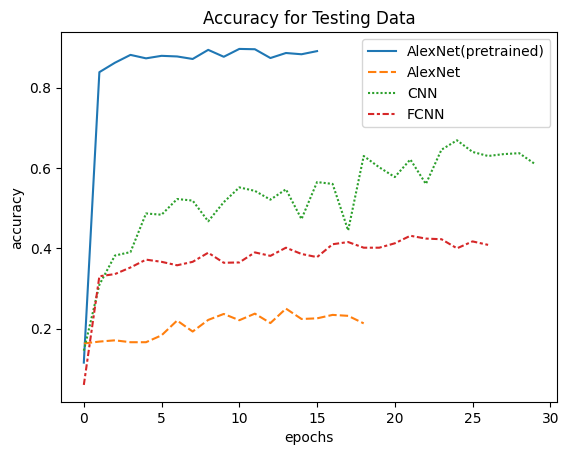

In [52]:
plot_accuracy({
    "AlexNet(pretrained)": alexnet_pretrained.acc_test,
    "AlexNet": alexnet.acc_test,
    "CNN": cnn.acc_test,
    "FCNN": fcnn.acc_test
}, title="Accuracy for Testing Data")

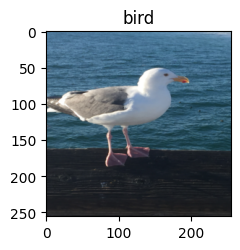

bird      :  99.8%
dog       :   0.1%
horse     :   0.0%



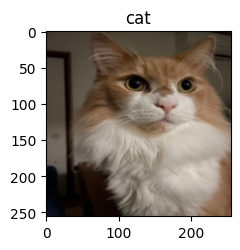

cat       :  99.5%
monkey    :   0.3%
dog       :   0.2%



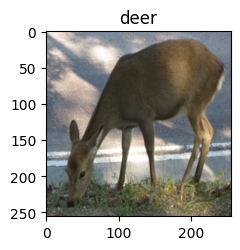

deer      :  87.4%
monkey    :   8.8%
horse     :   3.5%



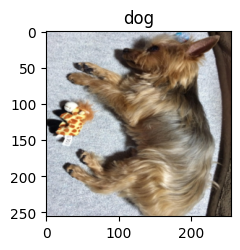

dog       :  64.8%
cat       :  27.4%
monkey    :   4.4%



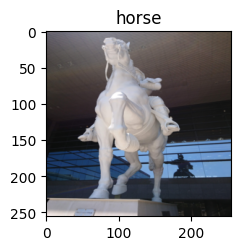

horse     :  95.7%
dog       :   3.3%
deer      :   0.4%

Acc@1 = 100.0% (5/5)
Acc@3 = 100.0% (5/5)


In [53]:
alexnet_pretrained.predict(dataloader_unknown, num_batches=1)